In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import accuracy, error_rate

In [2]:
image_path = Path('../image-data/02-disparity-maps/')
image_path.ls()

[PosixPath('../image-data/02-disparity-maps/high'),
 PosixPath('../image-data/02-disparity-maps/medium'),
 PosixPath('../image-data/02-disparity-maps/models'),
 PosixPath('../image-data/02-disparity-maps/low')]

In [3]:
image_size = 256
batch_size = 64
tfms = get_transforms()

In [4]:
data = (ImageList.from_folder(image_path, convert_mode='L')
       .split_by_rand_pct()
       .label_from_folder()
       .transform(tfms, size=image_size)
       .databunch(bs=batch_size)
       .normalize()) # Optional

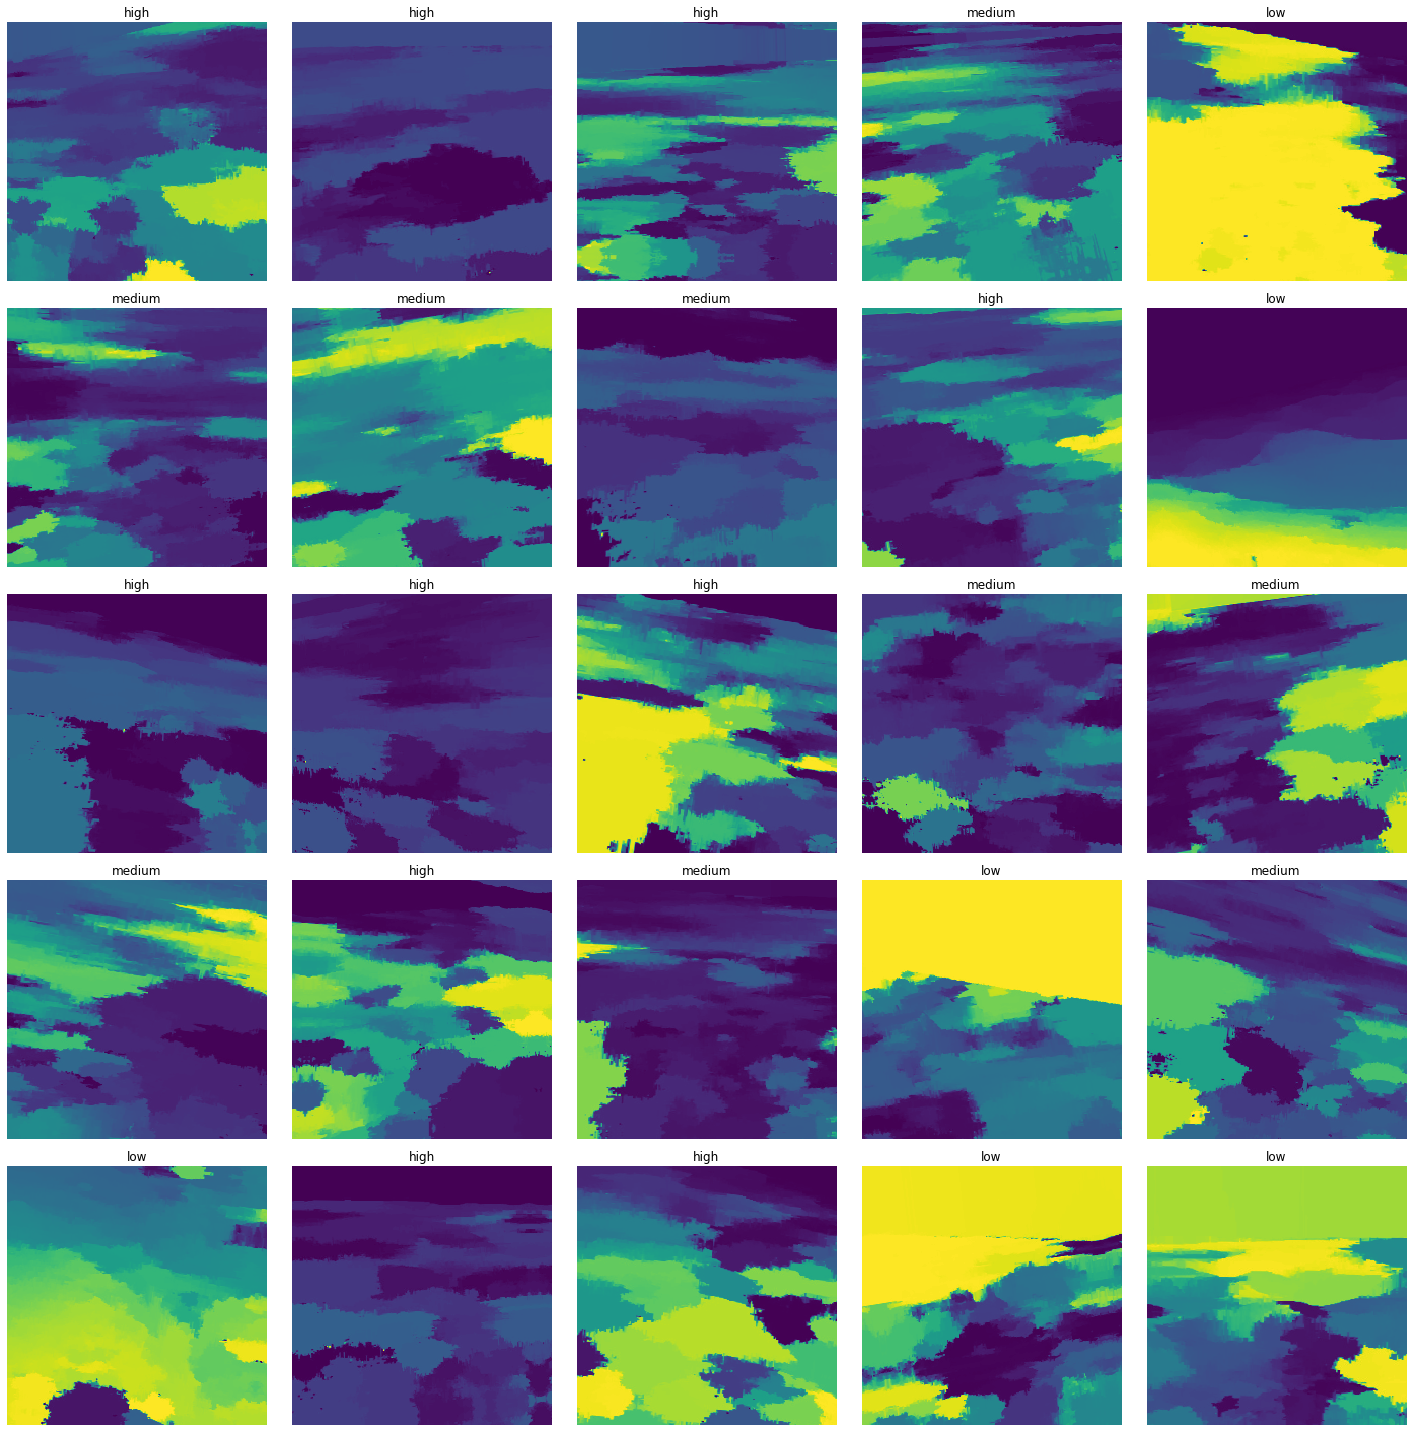

In [5]:
data.show_batch()

In [6]:
data

ImageDataBunch;

Train: LabelList (4709 items)
x: ImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
y: CategoryList
high,high,high,high,high
Path: ../image-data/02-disparity-maps;

Valid: LabelList (1177 items)
x: ImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
y: CategoryList
low,high,medium,medium,low
Path: ../image-data/02-disparity-maps;

Test: None

In [7]:
data.classes, data.c

(['high', 'low', 'medium'], 3)

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate], pretrained=False, callback_fns=ShowGraph)

In [9]:
learn.model[0][0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
learn.model.cuda();

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.200234,0.994427,0.519116,0.480884,00:18
1,1.036334,1.578916,0.415463,0.584537,00:16
2,0.931985,0.914469,0.555650,0.444350,00:17
3,0.852332,0.748829,0.640612,0.359388,00:16
4,0.794181,0.964387,0.564996,0.435004,00:16
5,0.751219,0.681061,0.665251,0.334749,00:17
6,0.722290,0.716450,0.666100,0.333900,00:17
7,0.682114,0.659747,0.700085,0.299915,00:17
8,0.631738,0.592675,0.715378,0.284622,00:17
9,0.612196,0.553289,0.740867,0.259133,00:16


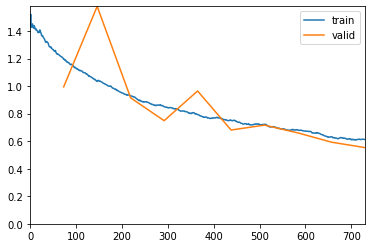

In [10]:
learn.fit_one_cycle(10)

In [11]:
learn.save('stage1-disparity-maps')

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

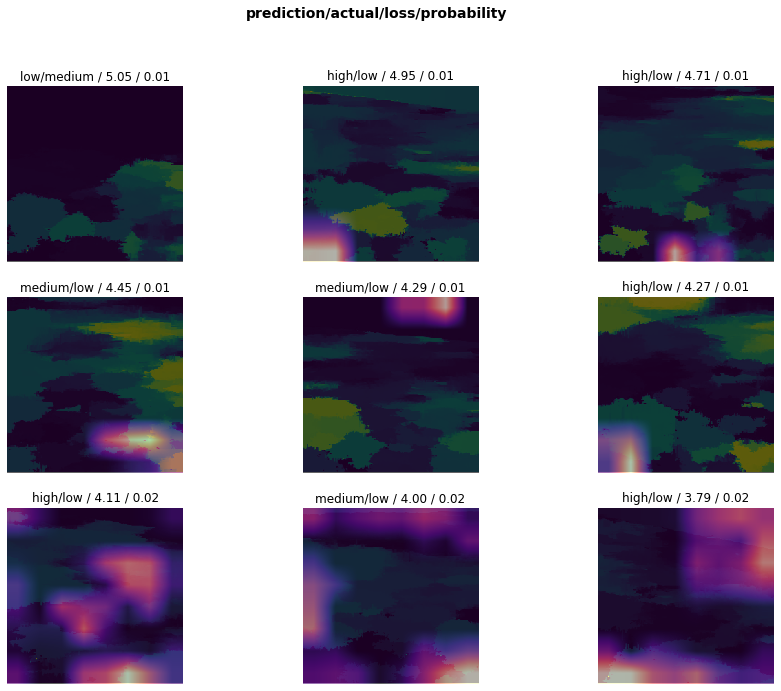

In [13]:
interp.plot_top_losses(9, figsize=(15,11))

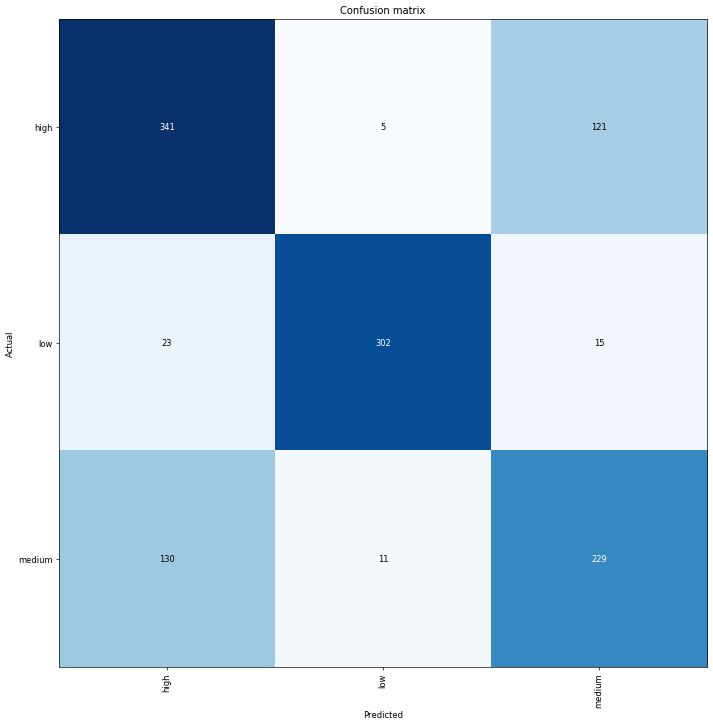

In [14]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [26]:
cm = interp.confusion_matrix(slice_size=1)
print(cm)

high_high = cm[0][0]
high_low = cm[0][1]
high_medium = cm[0][2]
high_row = [high_low, high_medium, high_high]

low_high = cm[1][0]
low_low = cm[1][1]
low_medium = cm[1][2]
low_row = [low_low, low_medium, low_high]

medium_high = cm[2][0]
medium_low = cm[2][1]
medium_medium = cm[2][2]
medium_row = [medium_low, medium_medium, medium_high]

cm = np.array([high_row, medium_row, low_row])
cm

[[341   5 121]
 [ 23 302  15]
 [130  11 229]]


array([[  5, 121, 341],
       [ 11, 229, 130],
       [302,  15,  23]])

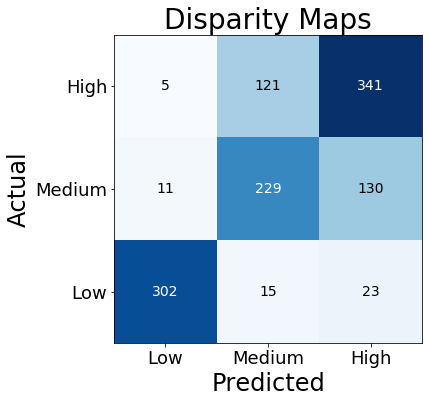

In [51]:
fig = plt.figure(figsize=(6,6)) # figsize, dpi, ...

plt.imshow(cm, interpolation='nearest', cmap="Blues")
plt.title("Disparity Maps", fontsize=28)
plt.ylabel('Actual', fontsize=24)
plt.xlabel('Predicted', fontsize=24)

classes = ["Low", "Medium", "High"]
plt.xticks([0, 1, 2], classes, fontsize=18);
plt.yticks([2, 1, 0], classes, fontsize=18);

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    coeff = f'{cm[i, j]}'
    plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black",
            fontsize=14)

plt.tight_layout()
plt.grid(False)

In [52]:
fig.savefig('dm-confusion-matrix.pdf', bbox_inches='tight')

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


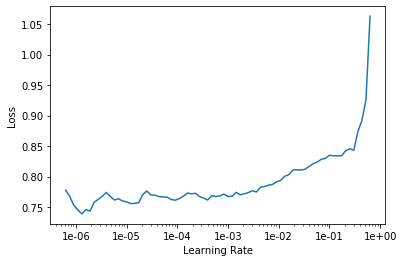

In [16]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.772129,0.703531,0.700102,0.299898,00:05
1,0.755348,0.697518,0.702149,0.297851,00:05
2,0.761756,0.695642,0.704197,0.295803,00:06
3,0.742932,0.695730,0.706244,0.293756,00:05


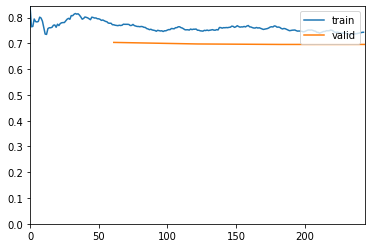

In [17]:
learn.load('stage1-disparity-maps')
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-4))

In [15]:
from time import time

learn.load('stage1-disparity-maps')
learn.model.training = False

grass_path = Path('../image-data/grass/2-dsp')
# grass_path = Path('../image-data/01-single-rgb/')

grass_path.ls()

[PosixPath('../image-data/grass/2-dsp/high'),
 PosixPath('../image-data/grass/2-dsp/medium'),
 PosixPath('../image-data/grass/2-dsp/low')]

In [17]:
# Doing this in a loop to get running times

clsses = ['high', 'medium', 'low']
totals = [0, 0, 0]
correct = [0, 0, 0]

total_time = 0

for clss_idx, clss in enumerate(clsses):
    grass_fnames = grass_path/clss
    print(grass_fnames)
    for grass_fname in grass_fnames.glob('**/*.jpg'):
        
        img = open_image(grass_fname, convert_mode='L')
        
        tstart = time()
        pred = learn.predict(img)
        total_time += time() - tstart
        
        if str(pred[0]) == clss:
            correct[clss_idx] += 1
        totals[clss_idx] += 1

../image-data/grass/2-dsp/high
../image-data/grass/2-dsp/medium
../image-data/grass/2-dsp/low


In [18]:
print(correct)
print(totals)
print([c/t*100 for c, t in zip(correct, totals)])
print(sum(correct)/sum(totals)*100)
print(total_time)

[113, 150, 251]
[284, 295, 295]
[39.7887323943662, 50.847457627118644, 85.08474576271186]
58.81006864988558
5.000740051269531
